In [2]:
import os
import cv2
import glob
from PIL import Image
import numpy as np
import text_spotting_utils as utils
from translate import Translator

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
IMAGE_DIR = os.path.join('.', 'sample_data')
IMAGE_PATHS = glob.glob(os.path.join(IMAGE_DIR, '*.jpg'))

MODELS_DIR = os.path.join('C:\\', '_local', 'models')
DETECTION_PATH = os.path.join(MODELS_DIR, 'db_ic15_resnet50.onnx')
RECOGNITION_PATH = os.path.join(MODELS_DIR, 'crnn_cs.onnx')

IN_BGR = False # Whether input images are already in BGR format

DETECTION_SIZE = (320, 320)
DISPLAY_SIZE = (480, 480)

sample_image = cv2.imread(IMAGE_PATHS[0])

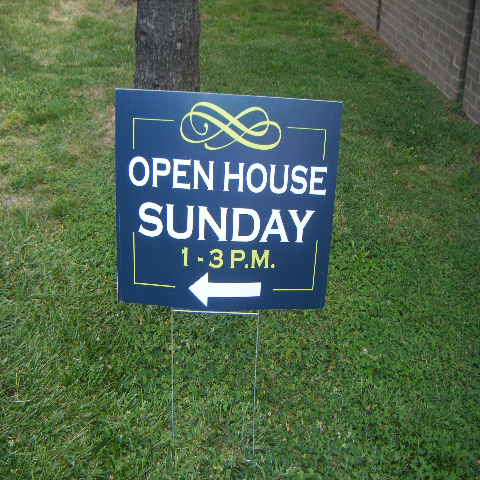

In [4]:
def display_image(img, dsize=(480, 480)):

    if isinstance(img, Image.Image):
        return img.resize(dsize)

    img = cv2.resize(img, dsize)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

display_image(sample_image)


## Detecting Scene Text

We can use a cv2 TextDetectionModel to detect text in images. This object handles image preprocessing, network inference, and post-processing of the network output to obtain the detections and their confidences. A Differential Binarization (DB) network is used for this model.

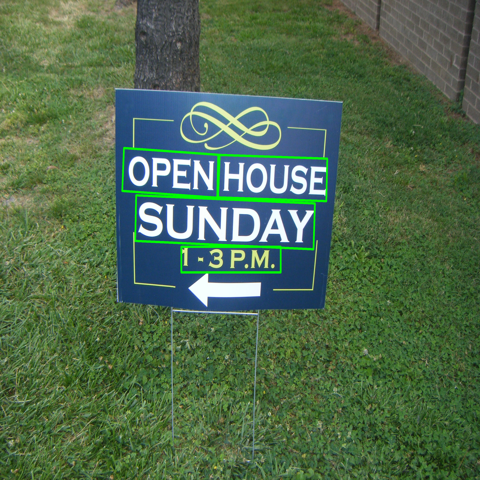

In [5]:
det_model = utils.get_detection_model(DETECTION_PATH, DETECTION_SIZE, IN_BGR)
detections, conf = det_model.detect(sample_image)

img_det = cv2.polylines(sample_image.copy(), detections, True, (0, 255, 0), 10)
img_det = cv2.cvtColor(img_det, cv2.COLOR_BGR2RGB)
img_det = Image.fromarray(img_det)

display_image(img_det)

## Recognizing Scene Text

Once we have the detections, we then run the detections through a recognition model which handles pre-processing, inference, and post-processing of a TextRecognition network.

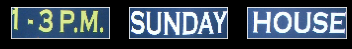

In [6]:
cropped_detections = [
    utils.fourPointsTransform(sample_image, det)
    for det in detections
]

fig, axes = plt.subplots(1, 3)
for ax, det in zip(axes, cropped_detections):
    _det = cv2.cvtColor(det, cv2.COLOR_BGR2RGB)
    ax.imshow(_det)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [9]:
rec_model = utils.get_recognition_model(RECOGNITION_PATH, IN_BGR)

recognitions = utils.get_processed_recognition_results(
        sample_image, rec_model, detections
)

print('unordered recognitions:', recognitions)

unordered recognitions: ['open house', 'sunday', '-3p.m.']


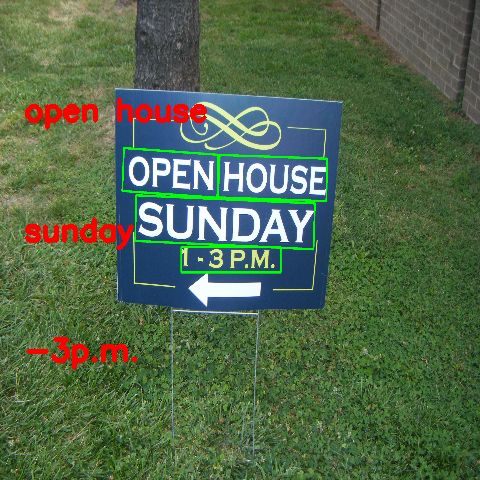

In [11]:
recognitions_image = sample_image.copy()
cv2.polylines(recognitions_image, detections, True, (0, 255, 0), 10)
recognitions_image = cv2.resize(recognitions_image, DISPLAY_SIZE)
utils.put_lines(recognitions_image, recognitions)
display_image(recognitions_image)

## Scene Text Translation

The extracted text is not always correct, as seen above where 'OPENHOUSE' is a single word. To attempt to mitigate this, a spell-checking library can be used. In this notebook and the accompanying scripts, a simple spell-checker is used.

Once the scene text has been extracted, the text can be translated. This project uses a module which can translate between most languages.

In [13]:
recognitions_str = ' '.join(recognitions)

es_translator = Translator(from_lang='en', to_lang='es')
zh_translator = Translator(from_lang='en', to_lang='zh')
zh_to_en_translator = Translator(from_lang='zh', to_lang='en')

spanish_recognitions = es_translator.translate(recognitions_str)
chinese_recognitions = zh_translator.translate(recognitions_str)
zh_to_en_recognitions = zh_to_en_translator.translate(chinese_recognitions)

print(f'spanish recognitions:\n{spanish_recognitions}\n')
print(f'chinese recognitions:\n{chinese_recognitions}\n')
print('chinese recognitions back to english:', zh_to_en_recognitions)

spanish recognitions:
jornada de puertas abiertas domingo -3p.m.

chinese recognitions:
开放参观

chines recognitions back to english: Open House


The Spanish translation is correct, but the Chinese translation is missing 'Sunday'.

In [14]:
# Grouping the Spanish translation into lines

spanish_recognitions_by_line, line = [], []
for w, word in enumerate(spanish_recognitions.split(' ')):
    if (w+1) % 4 == 0:
        spanish_recognitions_by_line.append(' '.join(line))
        line = []
    else:
        line.append(word)
spanish_recognitions_by_line.append(' '.join(line))

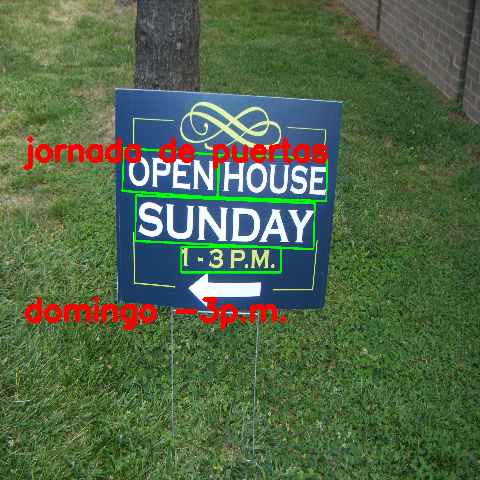

In [15]:
es_recognitions_image = sample_image.copy()
cv2.polylines(es_recognitions_image, detections, True, (0, 255, 0), 10)
es_recognitions_image = cv2.resize(es_recognitions_image, DISPLAY_SIZE)
utils.put_lines(es_recognitions_image, spanish_recognitions_by_line)
display_image(es_recognitions_image)

## Pipeline

Detection, recognition, and translation are all packaged into the utils.detection_recognition_translation_pipeline. Recognition and translation are optional. 

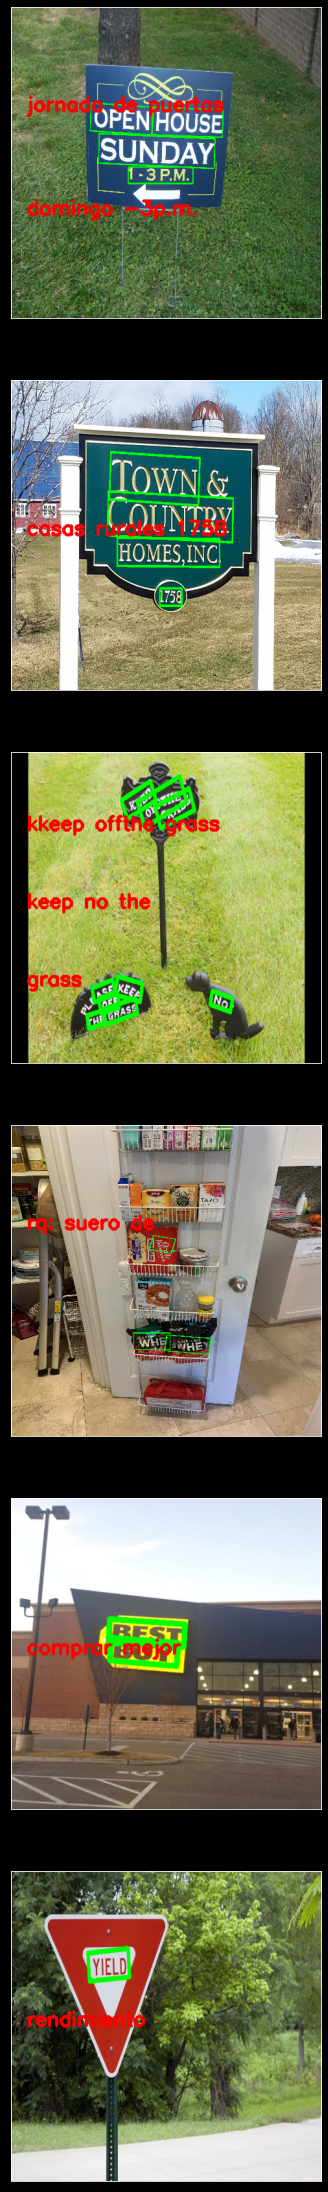

In [17]:
fig, axs = plt.subplots(6, 1, figsize=(20, 40))
axs = axs.reshape(-1,)

for img_path, ax in zip(IMAGE_PATHS, axs):

    img = cv2.imread(img_path)
    
    pipeline_results = utils.detection_recognition_translation_pipeline(
        img, det_model, rec_model, es_translator, 'translation failed :('
    )

    detections, recognitions, translations, draw_str = pipeline_results

    cv2.polylines(img, detections, True, (0, 255, 0), 10)
    img = cv2.resize(img, DISPLAY_SIZE)
    
    draw_lines = utils.string_to_lines(draw_str)
    utils.put_lines(img, draw_lines, 3, 3)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])